In [16]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
import pickle
from scipy.spatial.distance import cdist
import scipy
from scipy.stats import zscore
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

import anndata as an
import scanpy as sc
import scanpy.external as sce
import rapids_singlecell as rsc
import scvi

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 2

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 307 ms, sys: 1.23 s, total: 1.54 s
Wall time: 2min 14s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str', 'cluster'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'highly_variable_rank', 'variances', 'variances_norm'
    uns: 'batch_colors', 'cluster_colors', 'dr

In [3]:
adata.obs['batch'].value_counts()

batch
hsc    8357
fib    6960
Name: count, dtype: int64

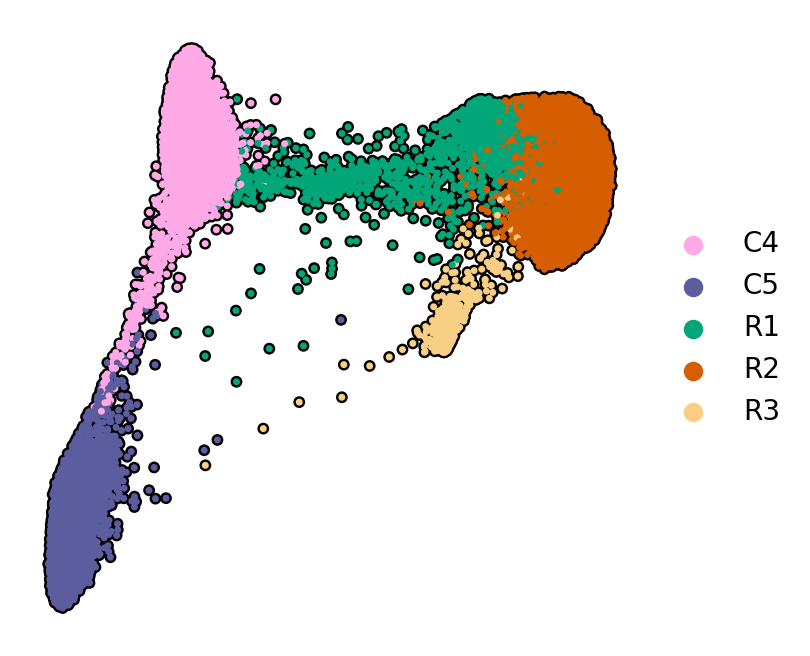

In [3]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['cluster'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    wspace=0.5,
)

# Score cell cycle genes

In [4]:
regev_genes = [x.strip() for x in open('/home/jrcwycy/githubrepositories/hybrid_reprogramming/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = regev_genes[:43]
g2m_genes = regev_genes[43:]

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
    layer='log_norm',   
)

adata.obs[['phase']].head()

calculating cell cycle phase
computing score 'S_score'
    finished (0:00:01)
computing score 'G2M_score'
    finished (0:00:01)


phase
AAACCCAAGGTTACCT-1_hsc    G1
AAACCCAAGTTGAAGT-1_hsc    G1
AAACCCAAGTTGTCGT-1_hsc     S
AAACCCACAGAAGCGT-1_hsc    G1
AAACCCACAGGAGGTT-1_hsc    G1

... storing 'phase' as categorical


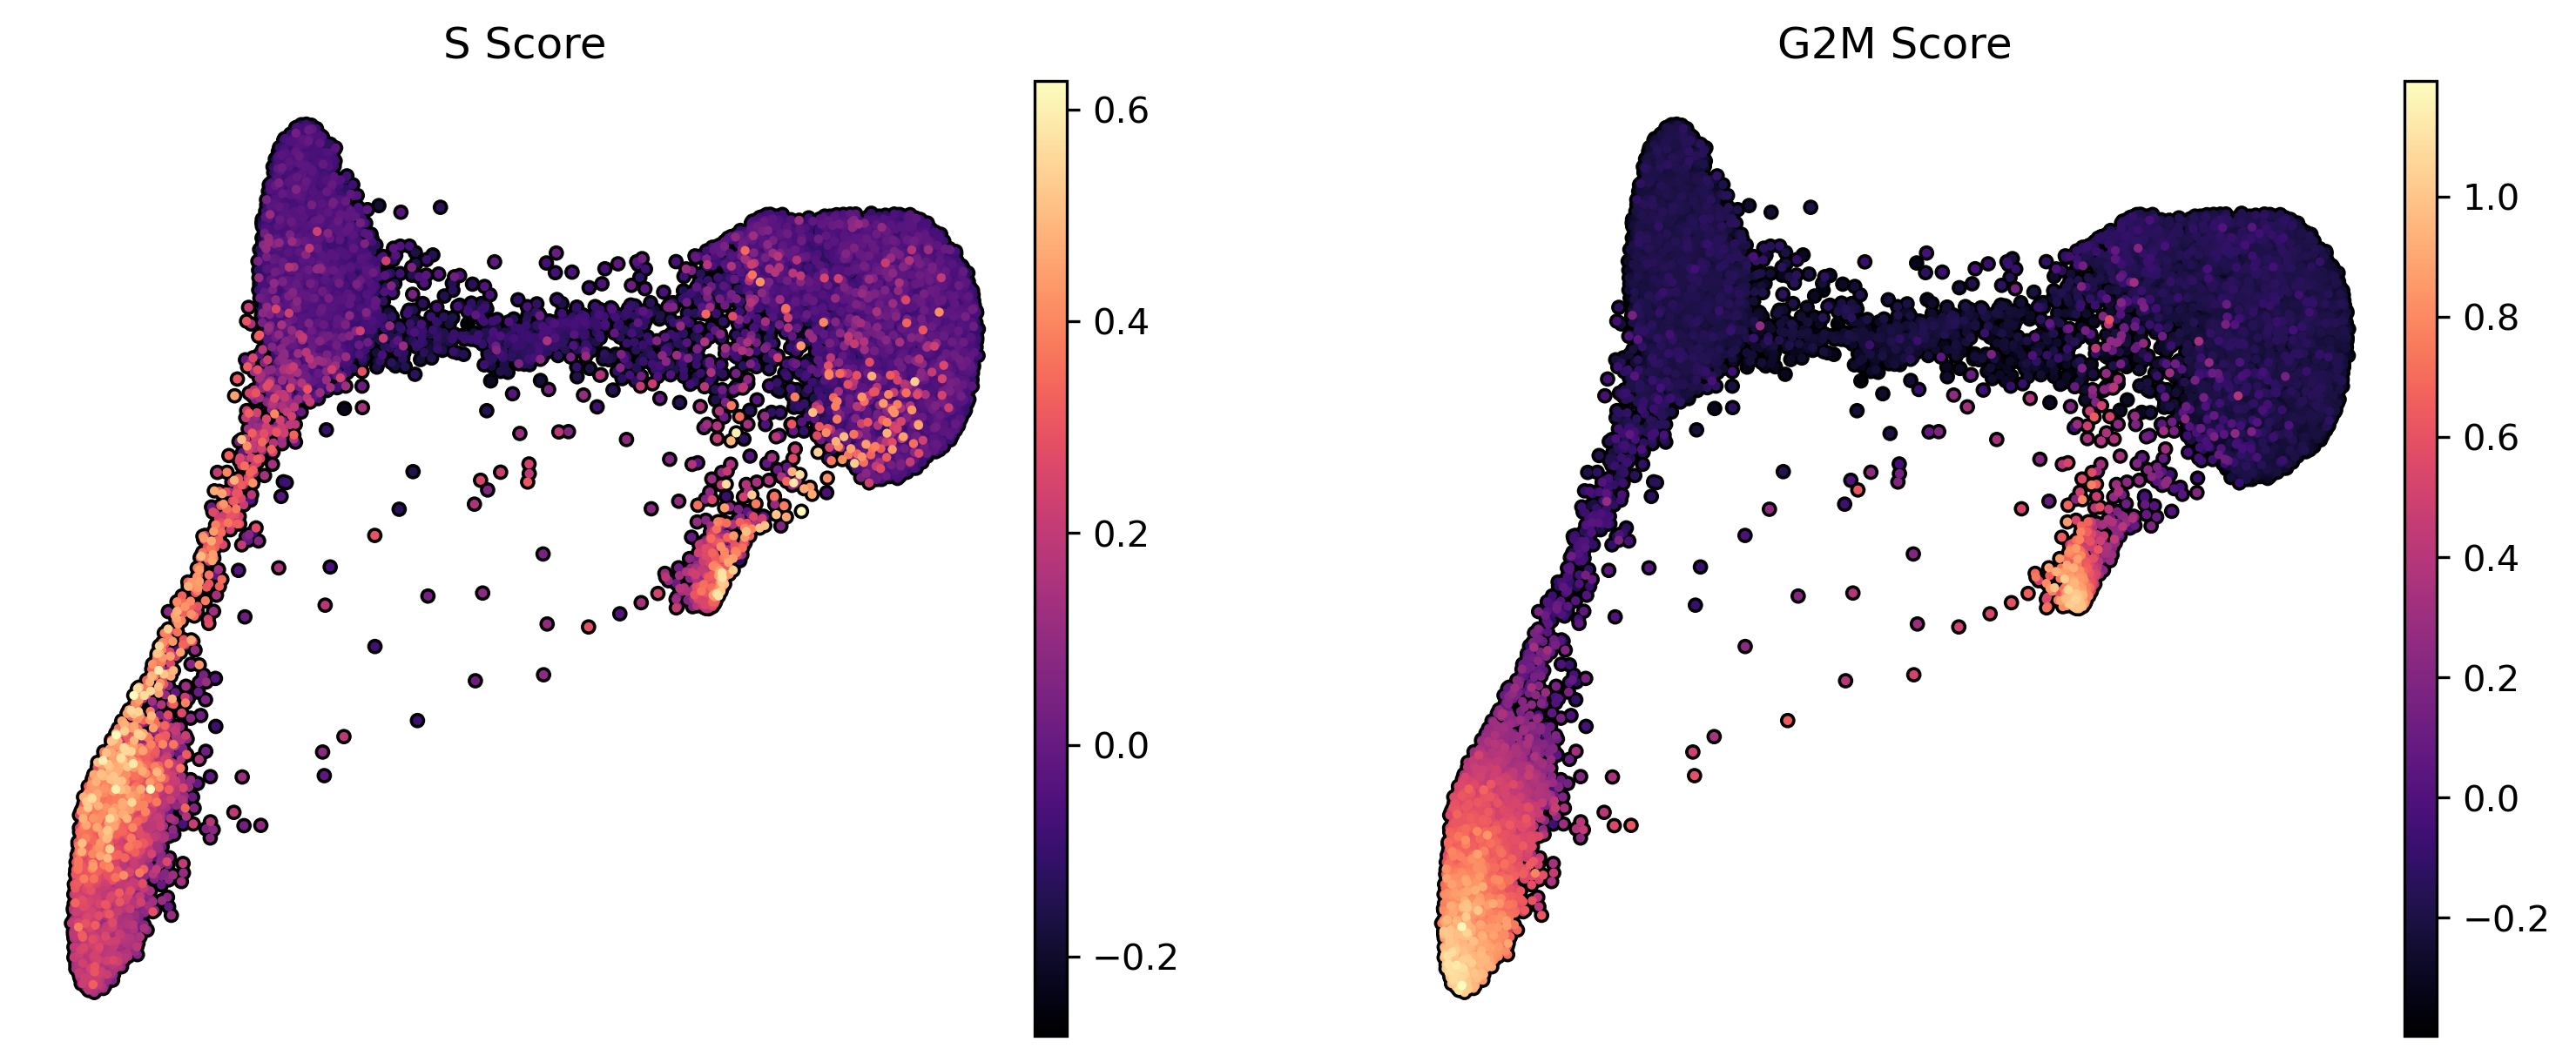

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.75, 4.75

sc.pl.draw_graph(
    adata, 
    # mask_obs=(adata.obs['batch'] == 'fib'),
    color=['S_score', 'G2M_score',],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    cmap='magma',
    outline_color=('k', 'k'),
    title=['S Score', 'G2M Score'],
    frameon=False,
    wspace=0.25,
)

In [14]:
adata.obs['S_score'].describe()

count    15317.000000
mean        -0.004378
std          0.156414
min         -0.274796
25%         -0.114697
50%         -0.071529
75%          0.096252
max          0.626990
Name: S_score, dtype: float64

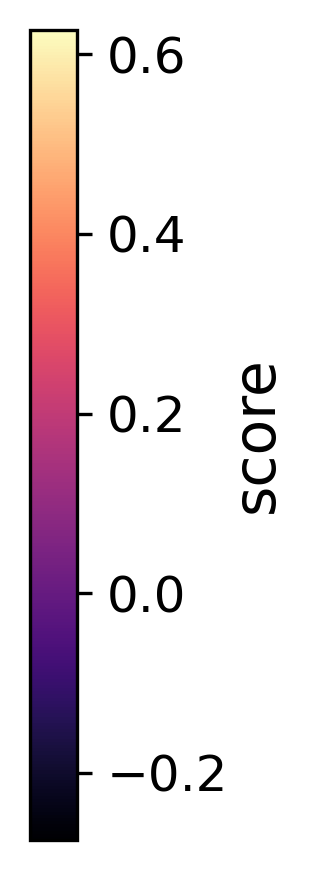

In [37]:
vmin = adata.obs['S_score'].min()
vmax = adata.obs['S_score'].max()
# vmin = adata.obs['G2M_score'].min()
# vmax = adata.obs['G2M_score'].max()

cmap = plt.cm.magma
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.15, 3 #1.15, 3 works for S   1.02, 3 works for G2M
fig, ax = plt.subplots()

cbar = plt.colorbar(
    sm,
    cax=ax,
    orientation='vertical',
    shrink=0.5,
)

# cbar.set_ticks([vmin, -1, 0, 1, vmax])
cbar.ax.tick_params(labelsize=12)
cbar.set_label('score', rotation=90, labelpad=0, fontsize=14)

plt.tight_layout()
plt.show()

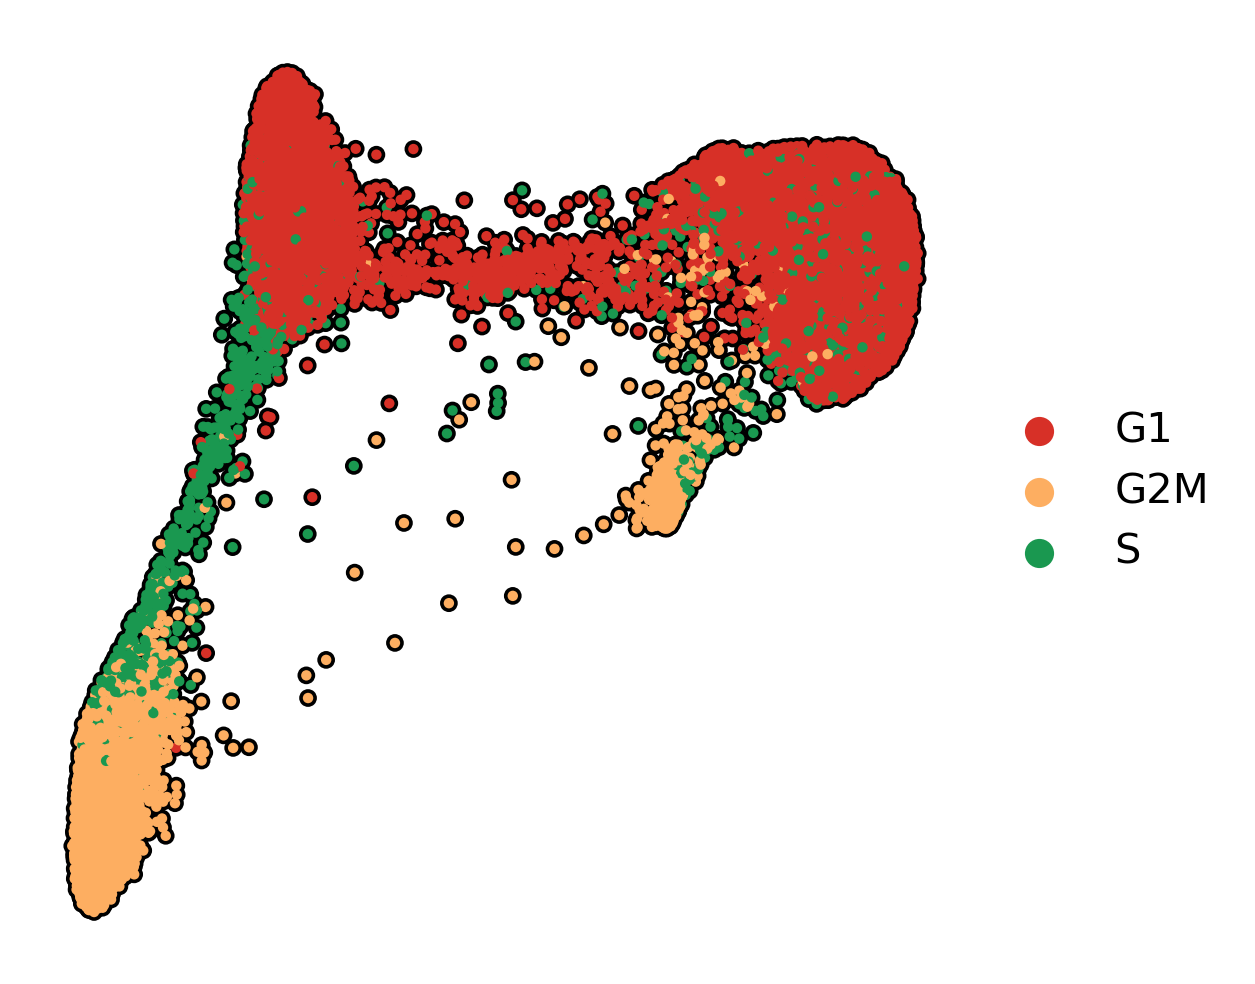

In [7]:
mask = adata.obs['cluster'].isin(['C4', 'C5'])

palette = {
    "G1": "#D73027",        # strong red (Cdt1+)
    "S": "#1A9850",         # green (Geminin+)
    "G2M": "#FDAE61",       # orange-yellow (Cdt1+/Geminin+)
    "unknown": "whitesmoke", # Neutral gray
}


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['phase'],
    # mask_obs=mask,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    # legend_loc='none',
    wspace=0.5,
    palette=palette,
)

In [9]:
low = '#131317' # dark
mid = '#3B80EB' # blue
high = '#F2D123' # yellow

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap",
    [(0.0, low), (0.15, low), (0.5, mid), (0.85, high), (1.0, high)]
)

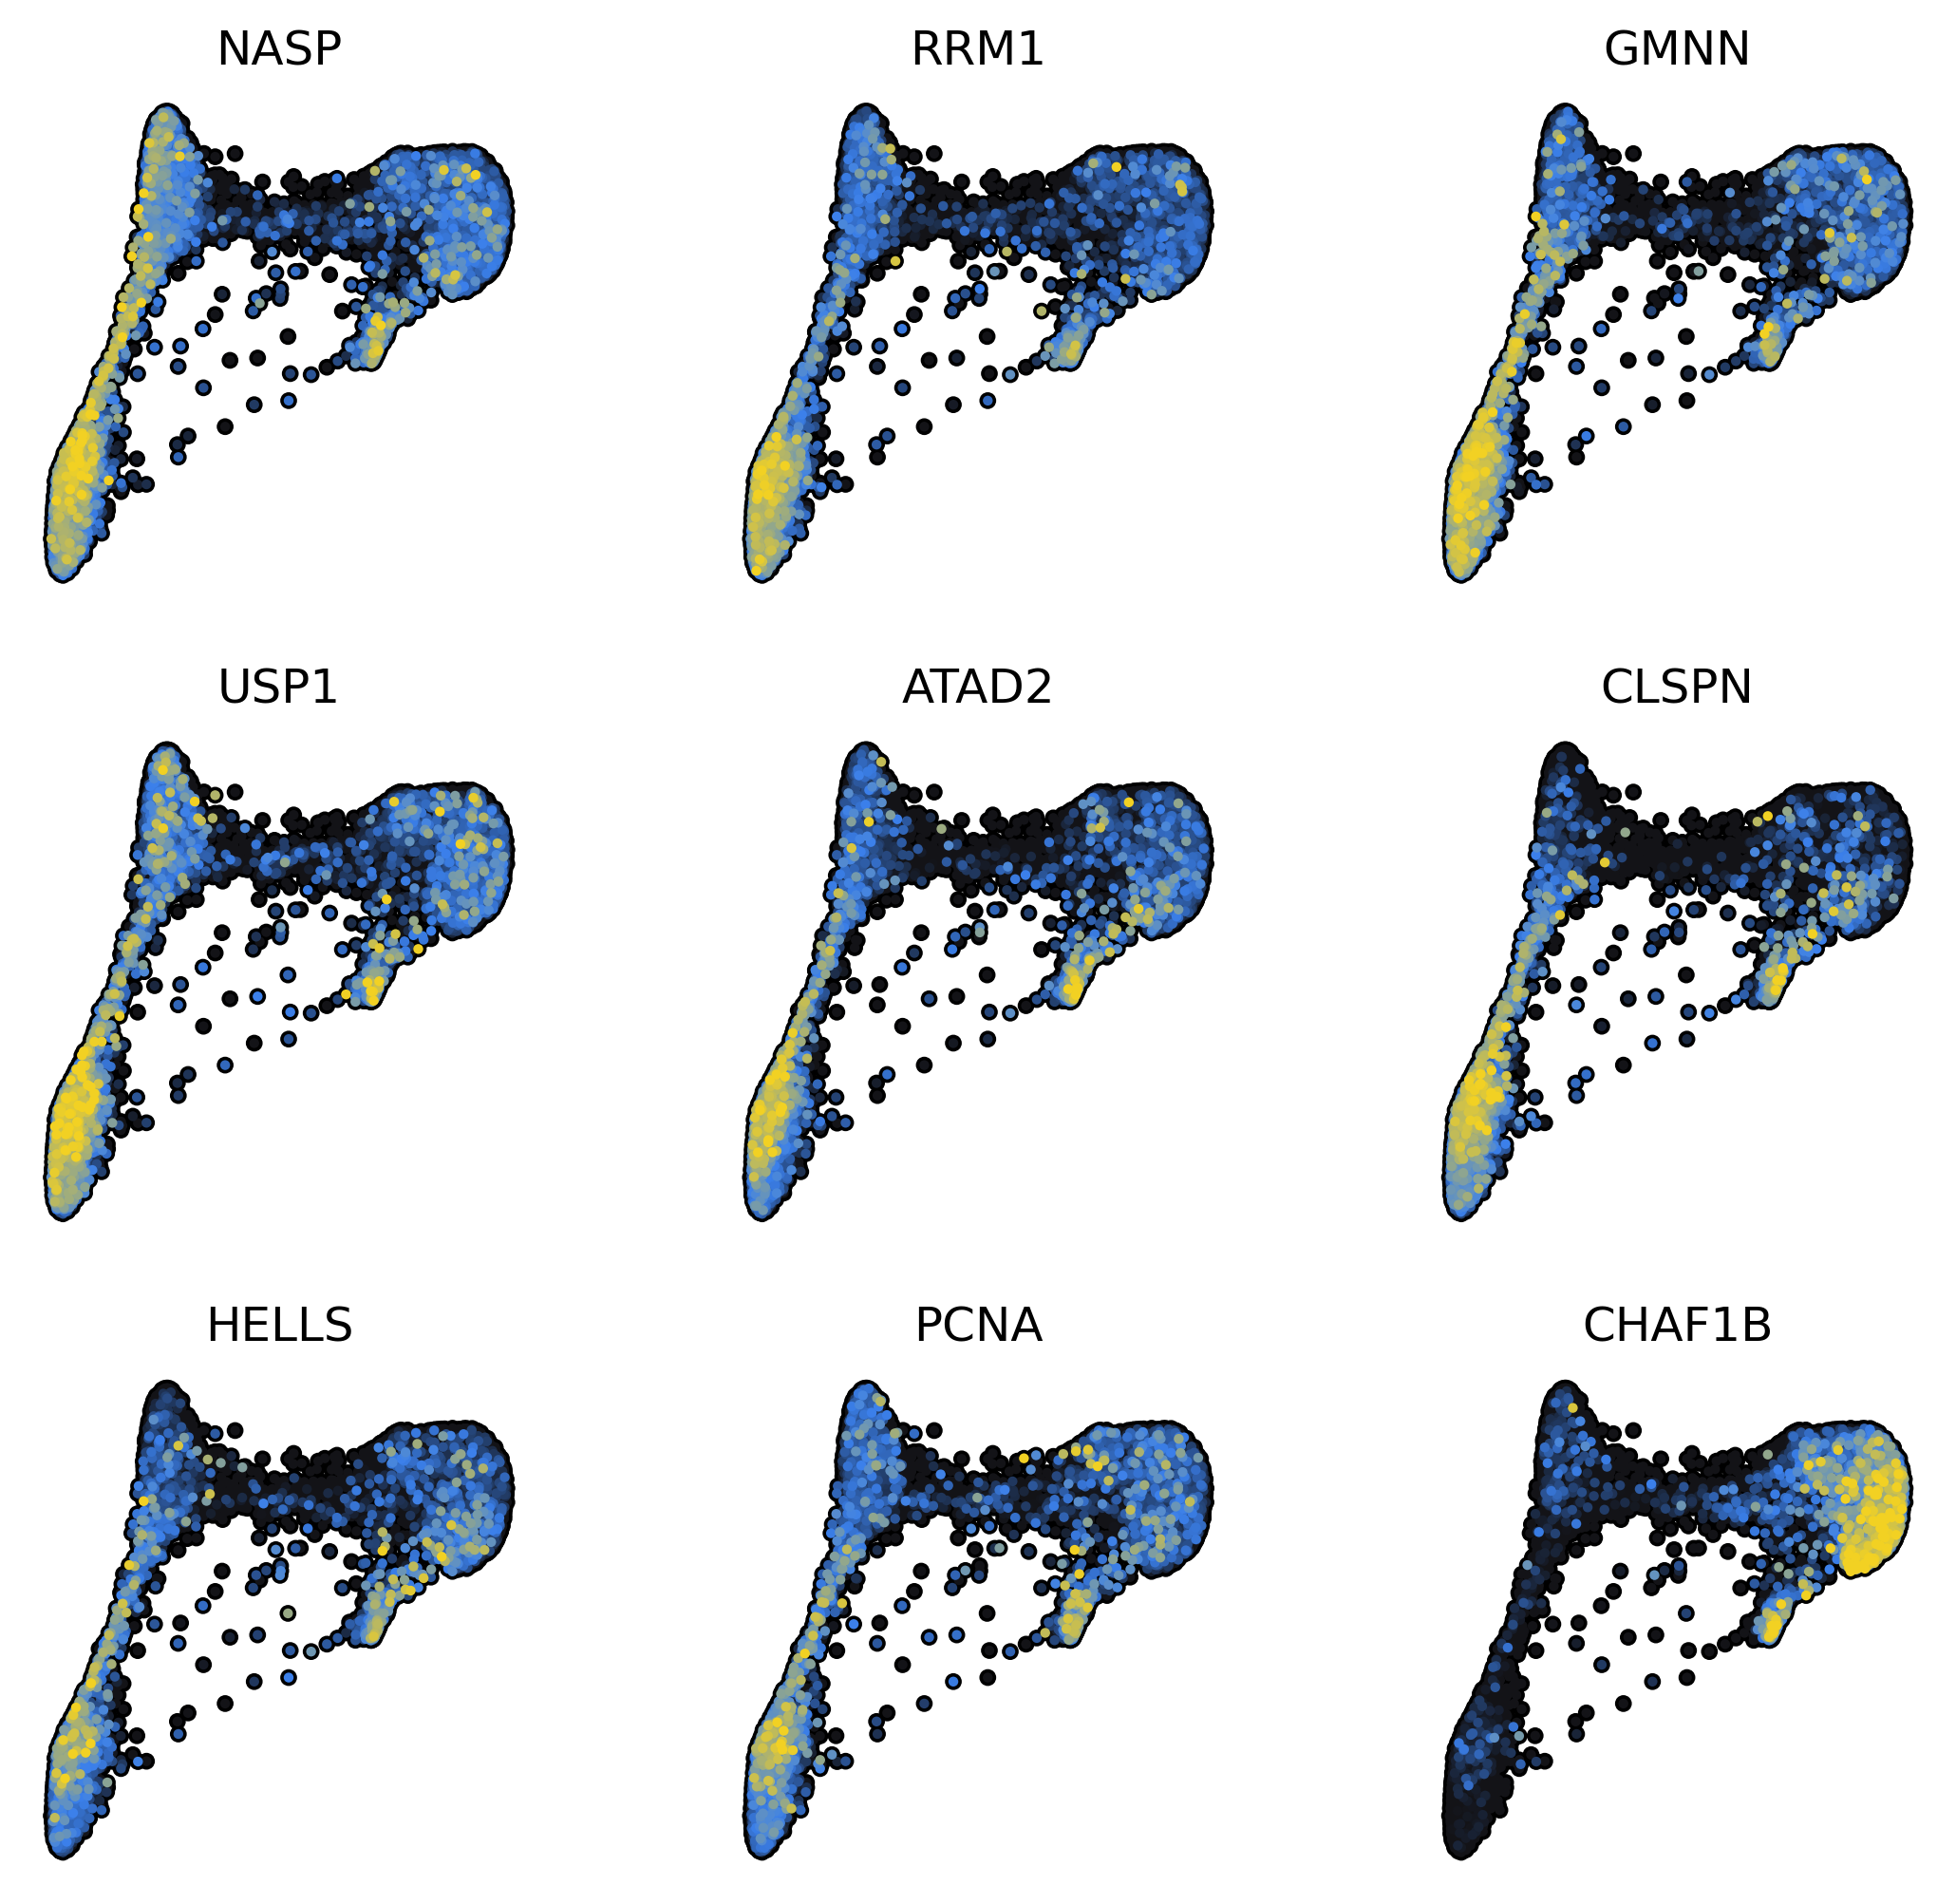

In [12]:
# get higest expressed S phase genes
adata.X = adata.layers['log_norm'].copy()

s_genes = [g for g in s_genes if g in adata.var_names]

mean_expr = adata[:, s_genes].X.mean(axis=0).A1  
top9_genes = [s_genes[i] for i in mean_expr.argsort()[::-1][:9]]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5

fig = sc.pl.draw_graph(
    adata, 
    color=top9_genes,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    cmap=custom_cmap,
    colorbar_loc=None,
    outline_color=('k', 'k'),
    frameon=False,
    show=False, 
    return_fig=True,  
)

# fig.suptitle("S Phase Genes", y=0.95)
plt.show()

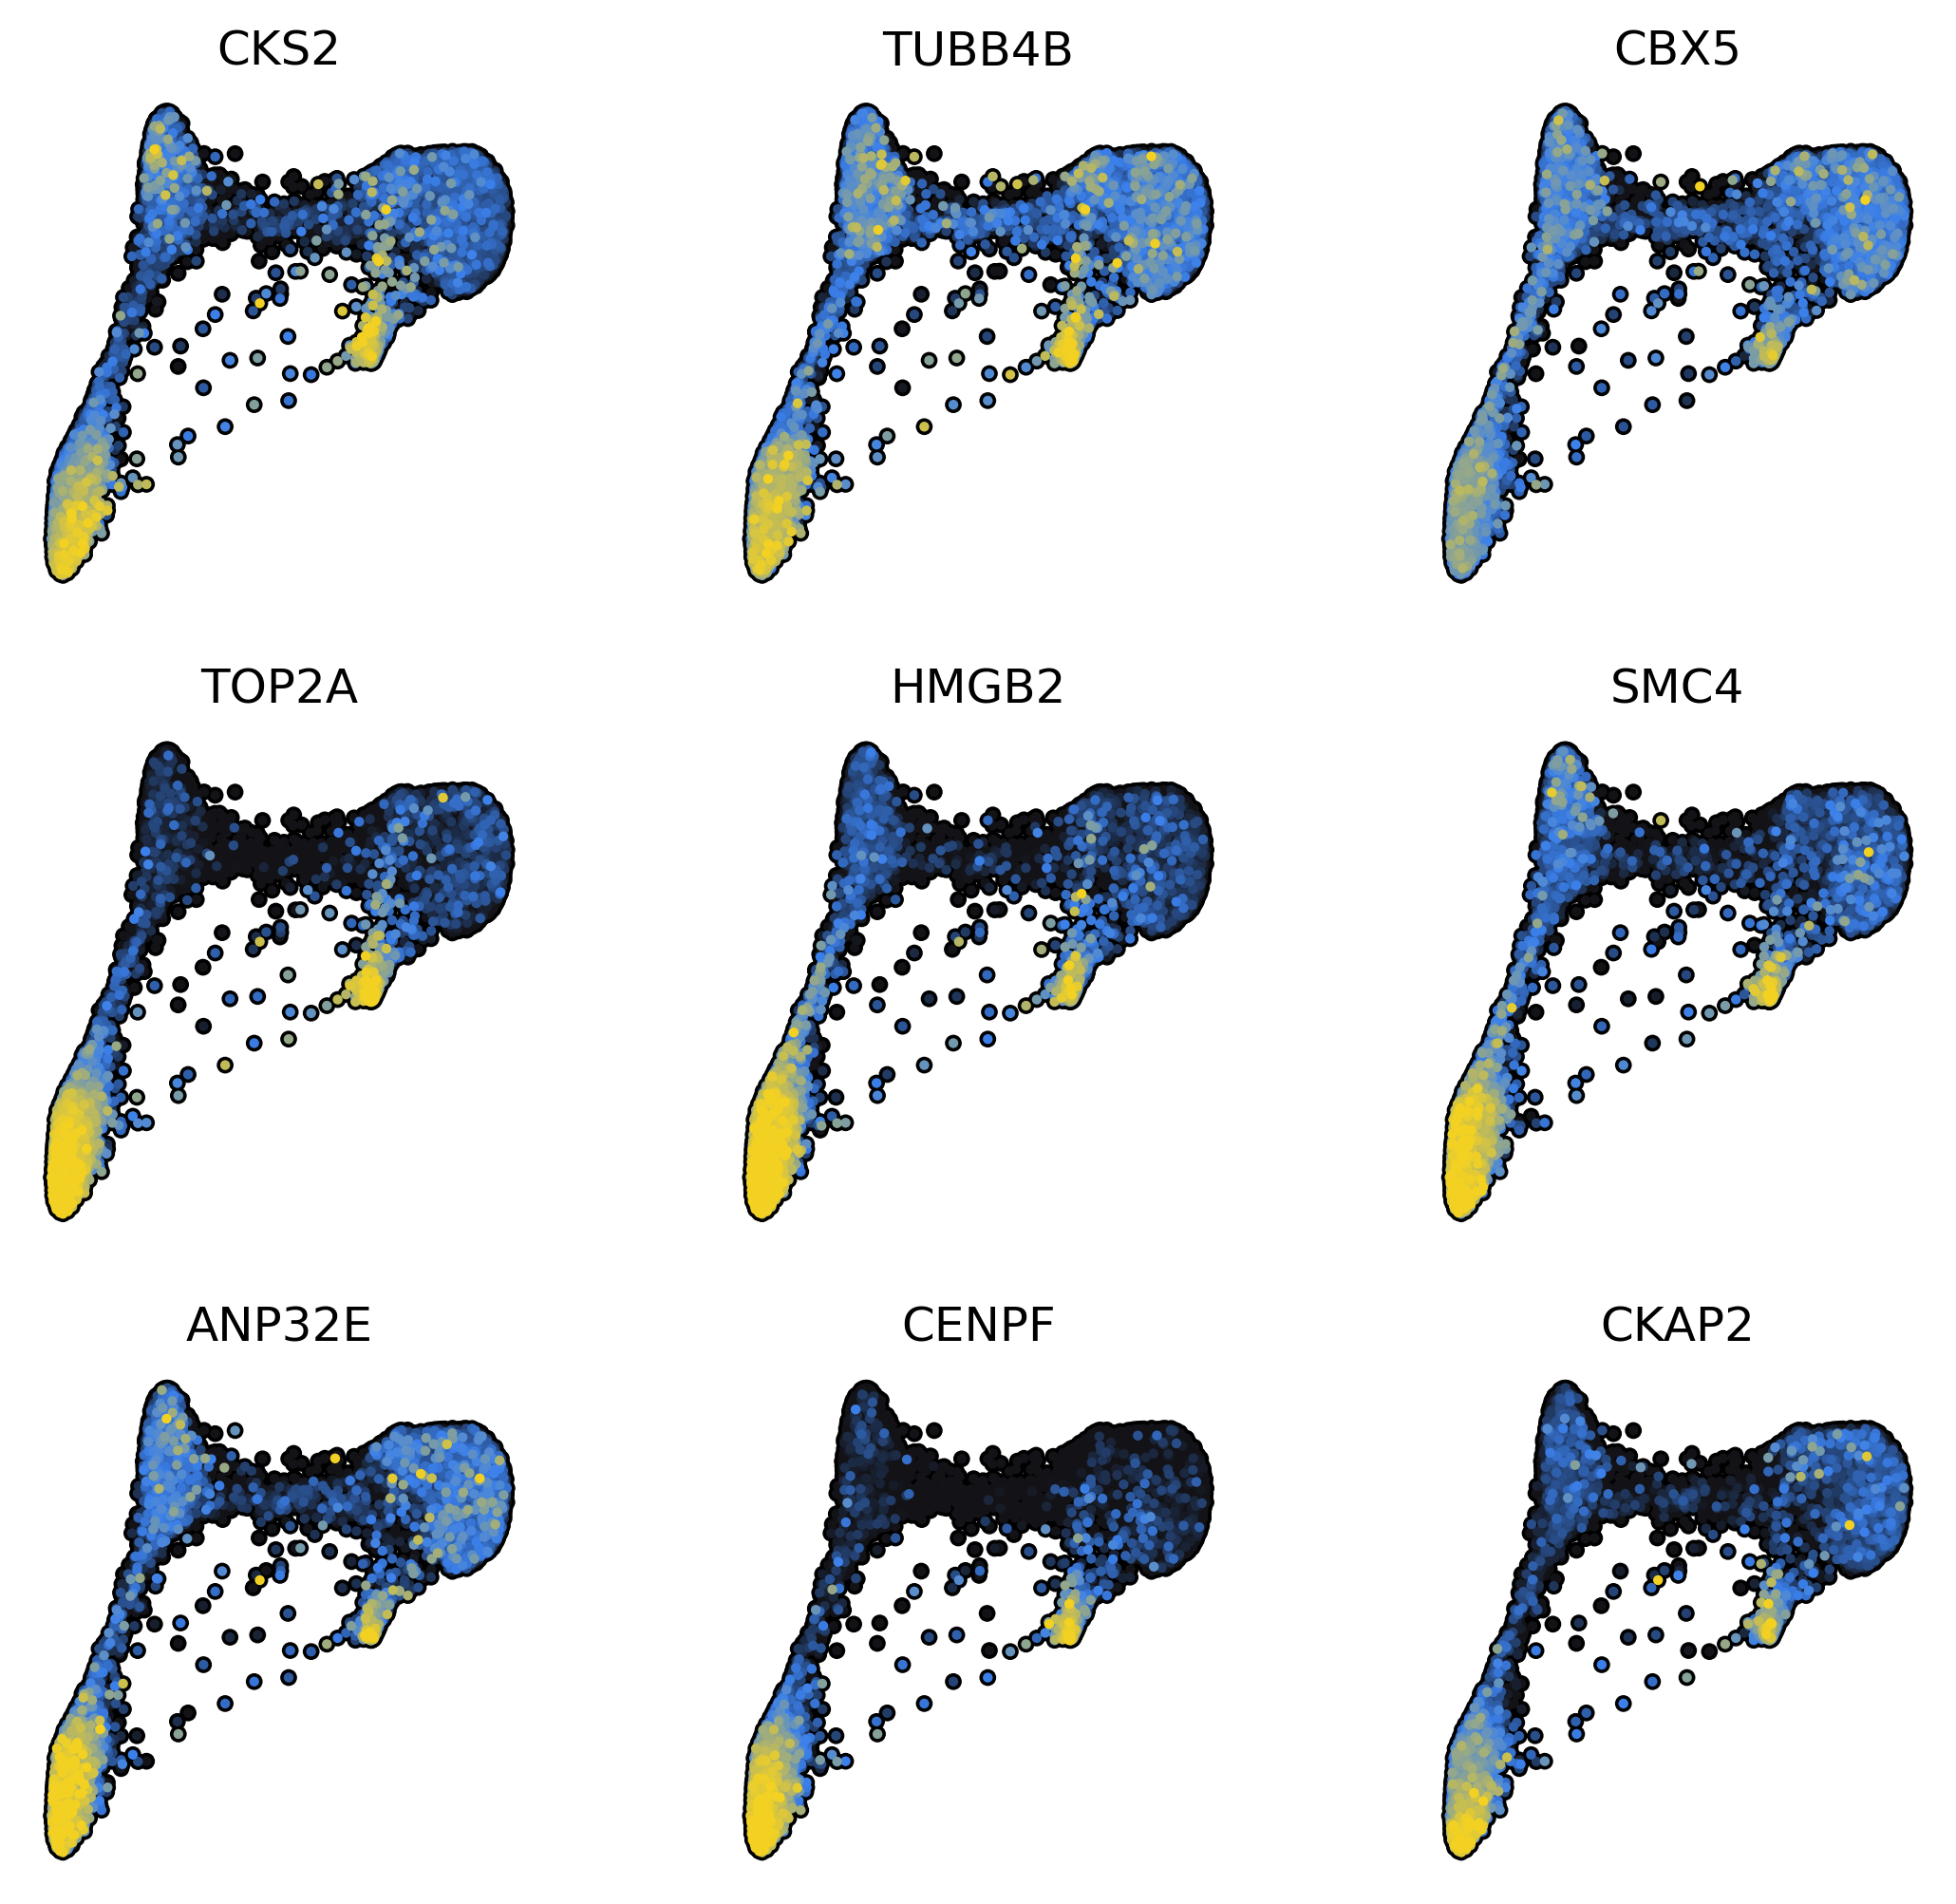

In [13]:
# get higest expressed G2M phase genes

g2m_genes = [g for g in g2m_genes if g in adata.var_names]

mean_expr = adata[:, g2m_genes].X.mean(axis=0).A1  
top9_genes = [g2m_genes[i] for i in mean_expr.argsort()[::-1][:9]]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5

fig = sc.pl.draw_graph(
    adata, 
    color=top9_genes,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    cmap=custom_cmap,
    colorbar_loc=None,
    outline_color=('k', 'k'),
    frameon=False,
    show=False, 
    return_fig=True,  
)

# fig.suptitle("S Phase Genes", y=0.95)
plt.show()

# quiescence

In [38]:
fpath = "../resources/genes_for_scoring.csv"

df = pd.read_csv(fpath)
print(df.shape)
print(df.columns.tolist())
df.head()

qui_tfs = [gene for gene in df['quiescence'].unique() if gene in adata.var_names]
print(f"\nN quiescence TFs: {len(qui_tfs)}")

(512, 18)
['G1/S_transition', 'G2/M_transition', 'CC_checkpoints', 'Cell_cycle_reg', 'Pos_proliferation', 'Neg_proliferation', 'quiescence', 'AS', 'Chromatin', 'Circadian', 'Core_repro', 'NOTCH_signaling', 'Asymm_PCP', 'FOXO', 'p53_acyivity', 'DREAM/negE2F', 'senes_stress', 'sasp']

N quiescence TFs: 55


In [39]:
fpath = "../resources/quiescence_markers.csv"

qdf = pd.read_csv(fpath)
print(qdf.shape)
qdf.head()

print(qdf['source'].value_counts())

# remove these genes because specific to stem cell quiescence ? 
# qdf = qdf[qdf['source'] != 'Cheung_down']
# qdf = qdf[qdf['source'] != 'Cheung_up']

qdf_up = qdf[qdf['source'].str.endswith('_up')]
qui_up_genes = qdf_up['gene'].unique()
print(f"\nN genes UP in quiescence: {len(qui_up_genes)}")

qdf_down = qdf[qdf['source'].str.endswith('_down')]
qui_down_genes = qdf_down['gene'].unique()
print(f"N genes DOWN in quiescence: {len(qui_down_genes)}")

(198, 2)
source
Coller_up      87
Cheung_up      38
G1_to_G0_up    30
Coller_down    24
Cheung_down    19
Name: count, dtype: int64

N genes UP in quiescence: 151
N genes DOWN in quiescence: 42


computing score 'quiescence_TFs_score'
    finished (0:00:02)
computing score 'quiescence_genes_score'
    finished (0:00:02)
computing score 'quiescence_down_score'
    finished (0:00:01)


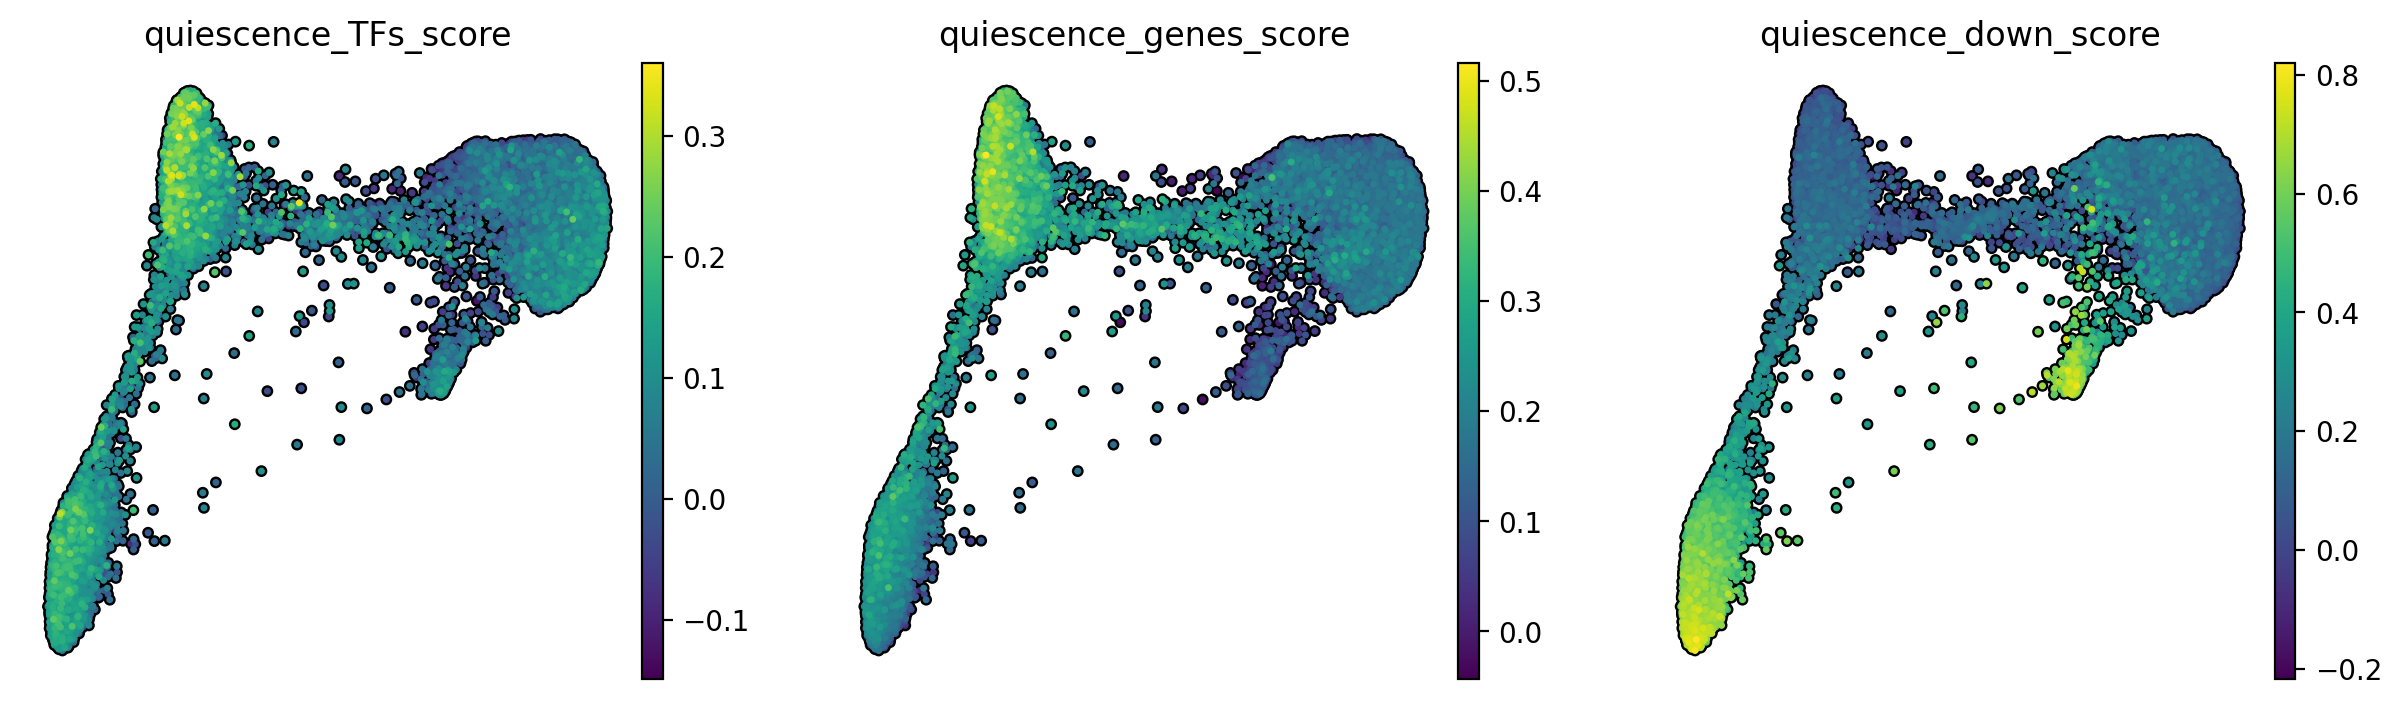

In [40]:
sc.tl.score_genes(
    adata,
    gene_list=qui_tfs,
    score_name='quiescence_TFs_score',
    ctrl_size=500,
    use_raw=False,
    layer='log_norm',
)

sc.tl.score_genes(
    adata,
    gene_list=qui_up_genes,
    score_name='quiescence_genes_score',
    ctrl_size=500,
    use_raw=False,
    layer='log_norm',
)

sc.tl.score_genes(
    adata,
    gene_list=qui_down_genes,
    score_name='quiescence_down_score',
    ctrl_size=500,
    use_raw=False,
    layer='log_norm',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['quiescence_TFs_score', 'quiescence_genes_score', 'quiescence_down_score'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
)

raw: 25
filtered: 17
computing score 'quiescence_score'
    finished (0:00:01)


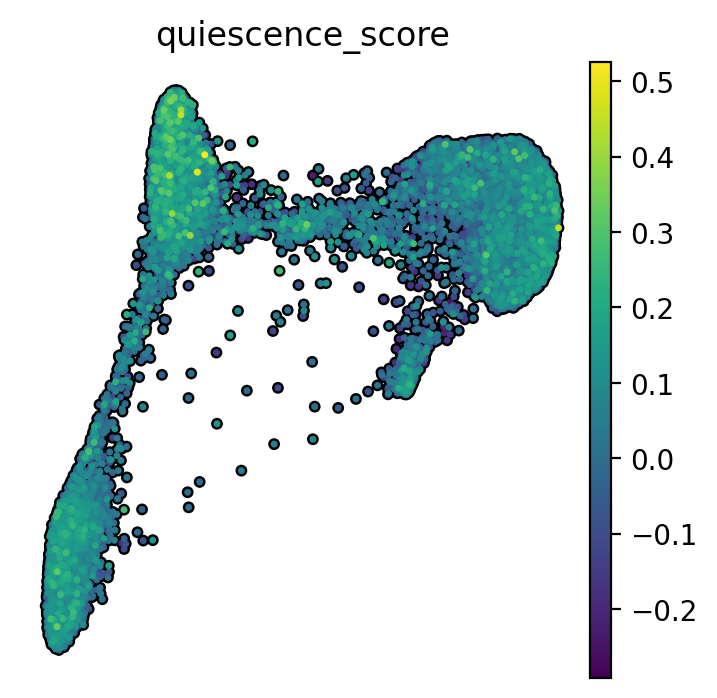

In [41]:
# HSC-related transcription factors with roles in quiescence/activation
gene_list = [
    "CTNNB1",   # β-catenin: promotes activation in hematopoietic stem cells
    "CEBPA",    # C/EBPα: maintains quiescence in hematopoietic stem cells
    "CTCF",     # CTCF: promotes activation of long-term quiescent HSCs
    "MECOM",    # Evi-1: maintains quiescence in hematopoietic stem cells
    "FOXM1",    # FOXM1: enforces quiescence, allows long-term self-renewal in HSC
    "FOXO3",    # FOXO: enforces quiescence and protects against ROS in HSC
    "GFI1",     # GFI1: restricts proliferation and promotes self-renewal in HSC
    "HLF",      # HLF: maintains stem cell pool and protects from stress in HSC
    "ID1",      # ID1: promotes exit from quiescence in HSC
    "ELF4",     # MEF/ELF4: promotes exit from quiescence in HSC
    "MYC",      # Myc: promotes proliferation and quiescence viability in HSC
    "NFKB1",    # NF-KB: promotes activation in hematopoietic stem cells
    "NKX2-3",   # NKX2-3: maintains self-renewal of hematopoietic stem cells
    "NFE2L2",   # Nrf2: maintains quiescence of hematopoietic stem cells
    "RARA",     # RARA: prevents exit from quiescence in HSC
    "NR1H3",    # NR1H3: prevents exit from quiescence in HSC
    "NR4A2",    # NR4A2 (NURR1): maintains quiescence in HSC
    "PBX1",     # PBX1: maintains quiescence in hematopoietic stem cells
    "SPI1",     # PU.1/SPI1: represses cell cycle and protein synthesis in HSC
    "SATB1",    # SATB1: promotes self-renewal and quiescence in HSC
    "TAL1",     # SCL/TAL1: impedes G0→G1 transition in HSC
    "TCF15",    # TCF15: drives quiescence and long-term self-renewal in HSC
    "TP53",     # TP53: enforces quiescence in HSC
    "YY1",      # YY1: maintains quiescence and long-term self-renewal in HSC
    "ZFP521",   # ZFP521: maintains quiescence in hematopoietic stem cells
]

print(f"raw: {len(gene_list)}")
gene_list = [x for x in gene_list if x in adata.var_names]
print(f"filtered: {len(gene_list)}")

sc.tl.score_genes(
    adata,
    gene_list=gene_list,
    score_name='quiescence_score',
    ctrl_size=500,
    use_raw=False,
    layer='log_norm',
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['quiescence_score'],
    size=25,
    ncols=1,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    frameon=False,
)

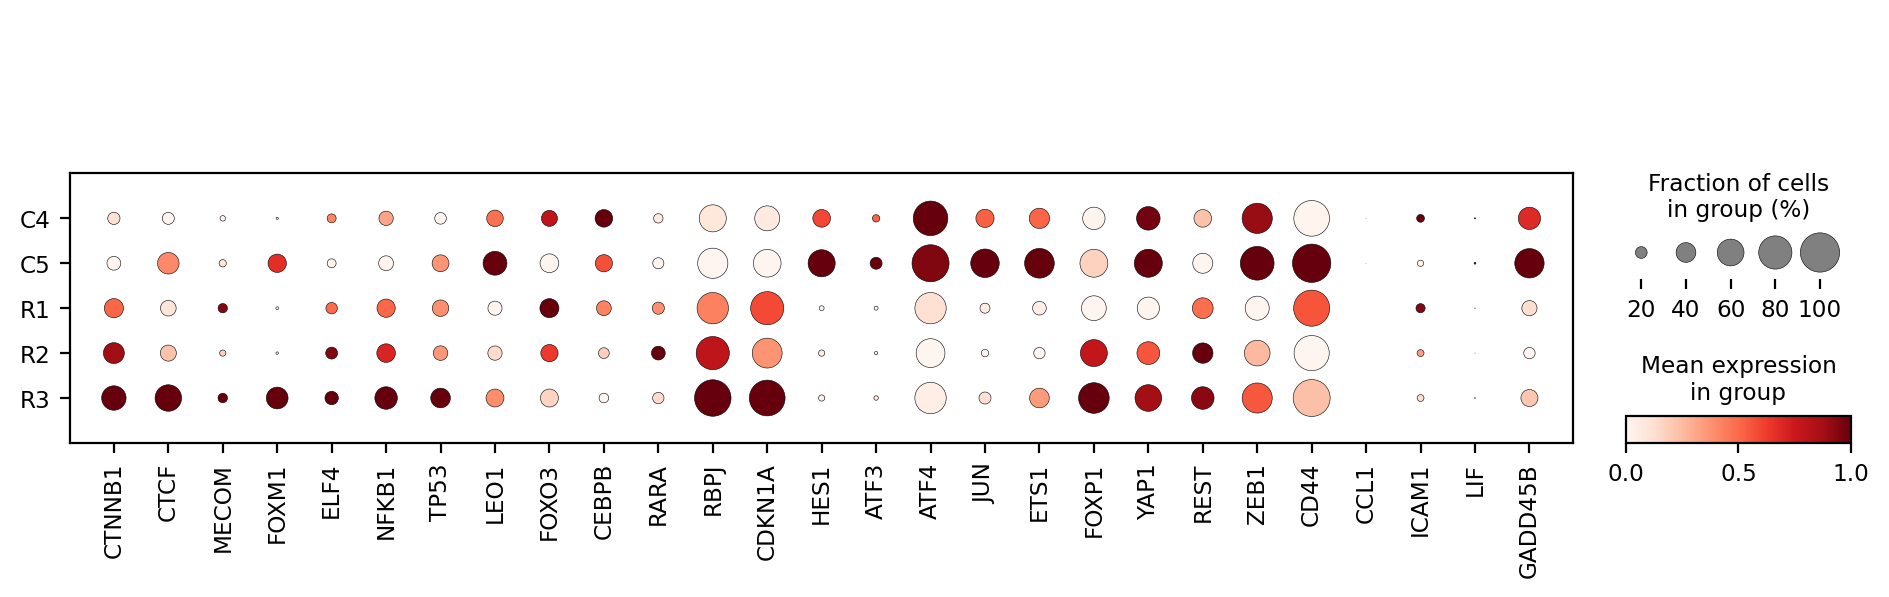

In [47]:
genes_to_plot = [
    'CTNNB1', 'CTCF', 'MECOM', 'FOXM1', 'ELF4', 'NFKB1', 'TP53', 'LEO1', 'FOXO3', 'CEBPB', 'RARA', 'RBPJ', 'CDKN1A', 'HES1',
    'ATF3', 'ATF4', 'JUN', 'ETS1', 'FOXP1', 'YAP1', 'REST', 'ZEB1', 'IFNG', 'CD44', 'CCL1', 'CCL9', 'ICAM1', 'LIF', 'LTA', 'GADD45B', 'TTC39C5',
]

genes_to_plot = [g for g in genes_to_plot if g in adata.var_names]

sc.pl.dotplot(
    adata,
    groupby='cluster',
    layer='log_norm',
    var_names=genes_to_plot,
    standard_scale='var',
)

In [44]:
qui_tfs

['ATF3',
 'ATF4',
 'CTNNB1',
 'BACH2',
 'JUN',
 'CEBPB',
 'CTCF',
 'E2F4',
 'E2F5',
 'E2F1',
 'E2F2',
 'E2F3',
 'ERG',
 'ETS1',
 'MECOM',
 'FOXC1',
 'FOXM1',
 'FOXO3',
 'FOXP1',
 'GATA6',
 'HES1',
 'ID1',
 'ID4',
 'KLF2',
 'KLF4',
 'KLF7',
 'KLF9',
 'LEF1',
 'MECP2',
 'MED1',
 'ELF4',
 'MXI1',
 'MYC',
 'NFKB1',
 'RBPJ',
 'NFE2L2',
 'RARA',
 'NR1H3',
 'NR4A2',
 'PAX3',
 'PBX1',
 'PPARD',
 'REST',
 'RUNX1',
 'SALL2',
 'SATB1',
 'STAT1',
 'STAT3',
 'STAT4',
 'TLE4',
 'TP53',
 'YAP1',
 'YY1',
 'ZEB1',
 'ZNF521']